In [1]:
from quimb import *
from quimb.tensor import *
import numpy as np
import quimb.tensor as qtn
import matplotlib.pyplot as plt
import cotengra as ctg
import quf
import quimb as qu
import itertools
import re

In [2]:
data_type='float64'
dist_type="normal"         #{'normal', 'uniform', 'exp'}
method="mgs"           #svd, qr, mgs, exp
jit_fn=False
phys_dim=2
chi=3
device='cpu'

tn_mera,list_sites, list_inter,tags_I, tags_U, list_scale=quf.MiniatureTN_build(phys_dim=phys_dim,chi=chi,data_type=data_type,dist_type=dist_type)


N_x, N_y, N_z 32 1 1 chi 3 chi_p 4 chi_p_0 4
I 32 0 [3, 3] [(-20, 0, 0), (-40, 0, 0)] [(0, 0, 0), (1, 0, 0)] {'l0,0,0': 'l0,0,0', 'l1,0,0': 'l1,0,0'}
I 32 0 [3, 3] [(-20, 0, 0), (-40, 0, 0)] [(4, 0, 0), (5, 0, 0)] {'l4,0,0': 'l2,0,0', 'l5,0,0': 'l3,0,0'}
I 32 0 [3, 3] [(-20, 0, 0), (-40, 0, 0)] [(8, 0, 0), (9, 0, 0)] {'l8,0,0': 'l4,0,0', 'l9,0,0': 'l5,0,0'}
I 32 0 [3, 3] [(-20, 0, 0), (-40, 0, 0)] [(12, 0, 0), (13, 0, 0)] {'l12,0,0': 'l6,0,0', 'l13,0,0': 'l7,0,0'}
I 16 1 [3, 3] [(-20, 0, 0), (-40, 0, 0)] [(0, 0, 0), (1, 0, 0)] {'l0,0,0': 'l0,0,0', 'l1,0,0': 'l1,0,0'}
I 16 1 [3, 3] [(-20, 0, 0), (-40, 0, 0)] [(4, 0, 0), (5, 0, 0)] {'l4,0,0': 'l2,0,0', 'l5,0,0': 'l3,0,0'}
I 8 2 [3, 3] [(-20, 0, 0), (-40, 0, 0)] [(0, 0, 0), (1, 0, 0)] {'l0,0,0': 'l0,0,0', 'l1,0,0': 'l1,0,0'}


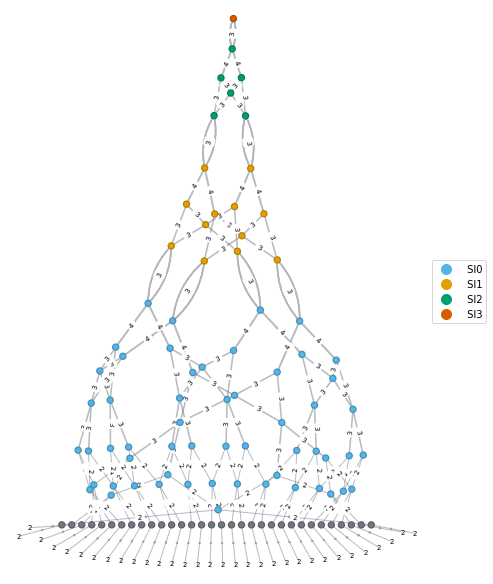

In [3]:
fix = {
      f'reg{i},{j},{k}': (i, 0,0) for i, j, k in itertools.product(range(tn_mera.Lx), range(tn_mera.Ly),range(tn_mera.Lz))
  }

#tags_I+tags_U
tn_mera.draw(list_scale,
         fix=fix, 
         show_tags=False, 
         legend=True, 
         figsize=(8, 8),
        show_inds='bond-size',
)

In [4]:
N_x = 2**7
N_y = 1
N_z = 1
tn = quf.TN3DUni.empty( N_x, N_y, N_z, phys_dim=2 )
tn_minat=quf.TN3DUni.empty( N_x, N_y, N_z, phys_dim=2 )
q_bond=4
n_layer=[0,0]
tags_U=[]
tags_I=[]
list_scale=[]

In [5]:
opt = ctg.ReusableHyperOptimizer(
     progbar=True,
     minimize='flops',       #{'size', 'flops', 'combo'}, what to target
     reconf_opts={}, 
     max_repeats=2**6,
     max_time=3600,
#    max_time='rate:1e6',
     parallel=True,
     #optlib='baytune',         # 'nevergrad', 'baytune', 'chocolate','random'
     directory="cash/"
 )
  #opt="auto-hq"


In [6]:
chi=5
chi_p=7

depth_init=2
#build_up chi
for depth in range( depth_init ):
     N_x_l=N_x//2**depth
     for i in range(0,N_x_l,2):
               where=[ ( (i+1)%N_x_l,0,0),( (i+2)%N_x_l,0,0) ]
               quf.apply_U(tn_minat,where,where, n_layer,tags_U,list_scale,scale=depth)
     for i in range(0,N_x_l,2):
              index_map={}
              where_in=[ (i,0,0),(i+1,0,0) ]
              where_out=[ (i,0,0) ]
              chi_out=[  min(2**(2*depth+2),chi)  ]
              quf.apply_I(tn_minat,where_in,where_out, n_layer,tags_I,list_scale,scale=depth, chi_out=chi_out,seed_val=i)
              index_map[f"l{i},{0},{0}"] =f"l{i-(i+1)//2},{0},{0}" 
              tn_minat.reindex_(index_map)
              #print ("I",depth,chi_out,where_in,where_out, index_map)

                
N_x_new=int(N_x//2**depth_init)
for depth in range( 0, int(np.log2(N_x_new))):
         N_x_l=N_x_new//2**depth
         for i in range(0,N_x_l,8):
                      where=[ ( (i+4)%N_x_l,0,0),( (i+5)%N_x_l,0,0),( (i+6)%N_x_l,0,0),( (i+7)%N_x_l,0,0) ]
                      if depth<int(np.log2(N_x_new))-2:            
                            quf.apply_U(tn_minat,where,where, n_layer,tags_U,list_scale,scale=depth)
                      where=[ ( (i+8)%N_x_l,0,0),( (i+9)%N_x_l,0,0),( (i+10)%N_x_l,0,0),( (i+11)%N_x_l,0,0) ]
                      if depth<int(np.log2(N_x_new))-2:            
                            quf.apply_U(tn_minat,where,where, n_layer,tags_U,list_scale,scale=depth)
                      where=[ ( (i+6)%N_x_l,0,0),( (i+7)%N_x_l,0,0),( (i+8)%N_x_l,0,0),( (i+9)%N_x_l,0,0) ]
                      if depth<int(np.log2(N_x_new))-2:            
                            quf.apply_U(tn_minat,where,where, n_layer,tags_U,list_scale,scale=depth)
                            print ("U", where)
                            
                            
                            
         if depth<int(np.log2(N_x_new))-2:                    
              for i in range(0,N_x_l,8):
                  index_map={}
                  where_in=[ (i,0,0),(i+1,0,0) ]
                  where_out=[ (-20,0,0) ]
                  chi_out=[ min( 2**(2*depth+2*depth_init+2),chi_p) ]
                  quf.apply_I(tn_minat,where_in,where_out, n_layer,tags_I,list_scale,scale=depth, chi_out=chi_out,seed_val=i)

                  where_in=[ (i+2,0,0),(i+3,0,0) ]
                  where_out=[ (-40,0,0) ]
                  chi_out=[ min(2**(2*depth+2*depth_init+2),chi_p) ]
                  quf.apply_I(tn_minat,where_in,where_out, n_layer,tags_I,list_scale,scale=depth, chi_out=chi_out,seed_val=i)
                    
                  where_in=[ (i+4,0,0),(i+5,0,0) ]
                  where_out=[ (-60,0,0) ]
                  chi_out=[ min(2**(2*depth+2*depth_init+2),chi_p) ]
                  quf.apply_I(tn_minat,where_in,where_out, n_layer,tags_I,list_scale,scale=depth, chi_out=chi_out,seed_val=i)

                  where_in=[ (i+6,0,0),(i+7,0,0) ]
                  where_out=[ (-80,0,0) ]
                  chi_out=[ min(2**(2*depth+2*depth_init+2),chi_p) ]
                  quf.apply_I(tn_minat,where_in,where_out, n_layer,tags_I, list_scale, scale=depth, chi_out=chi_out,seed_val=i)

                  print (  depth, 2**(2*depth+2*depth_init+2),chi_p)
                  where_in=[ (-20,0,0),(-40,0,0) ]
                  where_out=[ (i,0,0),(-100,0,0) ]
                  chi_out=[ min(2**(2*depth+2*depth_init+2),chi),min(2**(2*depth+2*depth_init+2),chi_p) ]
                  quf.apply_I(tn_minat,where_in,where_out, n_layer,tags_I, list_scale, scale=depth, chi_out=chi_out,seed_val=i)

                  where_in=[ (-60,0,0),(-80,0,0) ]
                  where_out=[ (-200,0,0),(i+3,0,0) ]
                  chi_out=[ min(2**(2*depth+2*depth_init+2),chi_p),min(2**(2*depth+2*depth_init+2),chi) ]
                  quf.apply_I(tn_minat,where_in,where_out, n_layer,tags_I, list_scale, scale=depth, chi_out=chi_out,seed_val=i)
                    
                    
                  where_in=[ (-100,0,0),(-200,0,0) ]
                  if depth<int(np.log2(N_x_new))-1:
                       where_out=[ (i+1,0,0),(i+2,0,0) ]
                       chi_out=[ min(2**(2*depth+2*depth_init+2),chi_p),min(2**(2*depth+2*depth_init+2),chi_p) ]
                  else:
                       where_out=[]
                       chi_out=[]

                  #print ("I",where_in,where_out)
                  quf.apply_I(tn_minat,where_in,where_out, n_layer,tags_I, list_scale, scale=depth, chi_out=chi_out,seed_val=i)
                  index_map[f"l{i},{0},{0}"] =f"l{i-(i+1)//2},{0},{0}" 
                  index_map[f"l{i+1},{0},{0}"] =f"l{i+1-(i+1)//2},{0},{0}" 
                  index_map[f"l{i+2},{0},{0}"] =f"l{i+2-(i+1)//2},{0},{0}" 
                  index_map[f"l{i+3},{0},{0}"] =f"l{i+3-(i+1)//2},{0},{0}" 

                  tn_minat.reindex_(index_map)
                  print ("I",depth,N_x_l, index_map)
         elif depth==int(np.log2(N_x_new))-2:                    
                  index_map={}
                  where_in=[ (0,0,0),(1,0,0) ]
                  where_out=[ (-20,0,0) ]
                  chi_out=[ min(2**(2*depth+2*depth_init+2),chi_p) ]
                  quf.apply_I(tn_minat,where_in,where_out, n_layer,tags_I,list_scale,scale=depth, chi_out=chi_out,seed_val=i)

                  where_in=[ (2,0,0),(3,0,0) ]
                  where_out=[ (-40,0,0) ]
                  chi_out=[ min(2**(2*depth+2*depth_init+2),chi_p) ]
                  quf.apply_I(tn_minat,where_in,where_out, n_layer,tags_I,list_scale,scale=depth, chi_out=chi_out,seed_val=i)
                  where_in=[ (-20,0,0),(-40,0,0) ]
                  where_out=[]
                  chi_out=[]
                  quf.apply_I(tn_minat,where_in,where_out, n_layer,tags_I, list_scale, scale=depth, chi_out=chi_out,seed_val=i)
                  print ("I_f",depth,N_x_l, where_in)
            
            
            
            
            
            

U [(6, 0, 0), (7, 0, 0), (8, 0, 0), (9, 0, 0)]
U [(14, 0, 0), (15, 0, 0), (16, 0, 0), (17, 0, 0)]
U [(22, 0, 0), (23, 0, 0), (24, 0, 0), (25, 0, 0)]
U [(30, 0, 0), (31, 0, 0), (0, 0, 0), (1, 0, 0)]
0 64 7
I 0 32 {'l0,0,0': 'l0,0,0', 'l1,0,0': 'l1,0,0', 'l2,0,0': 'l2,0,0', 'l3,0,0': 'l3,0,0'}
0 64 7
I 0 32 {'l8,0,0': 'l4,0,0', 'l9,0,0': 'l5,0,0', 'l10,0,0': 'l6,0,0', 'l11,0,0': 'l7,0,0'}
0 64 7
I 0 32 {'l16,0,0': 'l8,0,0', 'l17,0,0': 'l9,0,0', 'l18,0,0': 'l10,0,0', 'l19,0,0': 'l11,0,0'}
0 64 7
I 0 32 {'l24,0,0': 'l12,0,0', 'l25,0,0': 'l13,0,0', 'l26,0,0': 'l14,0,0', 'l27,0,0': 'l15,0,0'}
U [(6, 0, 0), (7, 0, 0), (8, 0, 0), (9, 0, 0)]
U [(14, 0, 0), (15, 0, 0), (0, 0, 0), (1, 0, 0)]
1 256 7
I 1 16 {'l0,0,0': 'l0,0,0', 'l1,0,0': 'l1,0,0', 'l2,0,0': 'l2,0,0', 'l3,0,0': 'l3,0,0'}
1 256 7
I 1 16 {'l8,0,0': 'l4,0,0', 'l9,0,0': 'l5,0,0', 'l10,0,0': 'l6,0,0', 'l11,0,0': 'l7,0,0'}
U [(6, 0, 0), (7, 0, 0), (0, 0, 0), (1, 0, 0)]
2 1024 7
I 2 8 {'l0,0,0': 'l0,0,0', 'l1,0,0': 'l1,0,0', 'l2,0,0': 'l2

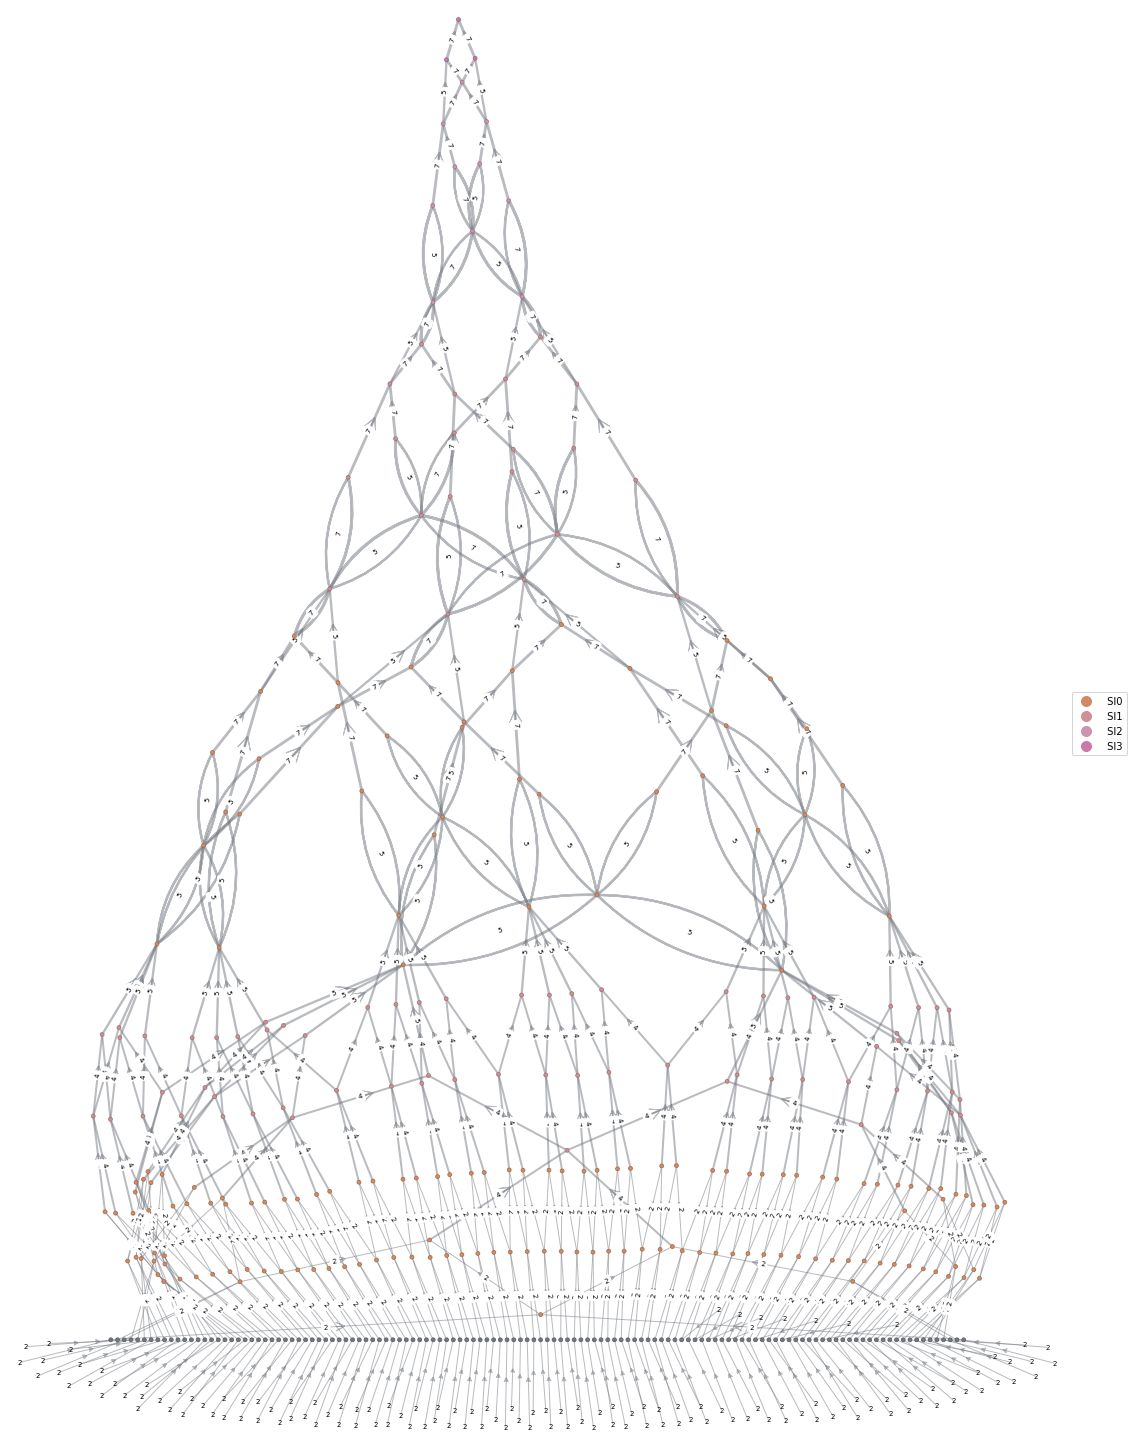

In [7]:
fix = {
      f'reg{i},{j},{k}': (i, 0,0) for i, j, k in itertools.product(range(tn.Lx), range(tn.Ly),range(tn.Lz))
  }


tn_minat.draw(list_scale,
        fix=fix, 
        show_tags=False, 
        legend=True, 
        figsize=(20, 20),
        show_inds='bond-size',
       )

In [8]:
list_sites, list_inter=quf.Heis_local_Ham_open_3D_1D_P(N_x,N_y,N_z, data_type="float64", phys_dim=2)

In [9]:
tn_mera.unitize_(method="mgs", allow_no_left_inds=True)
print ( "E_init=", quf.energy_f(tn_mera, list_sites, list_inter,optimize=opt) )
print ( "chi", tn_mera.max_bond() )

log2[SIZE]: 12.34 log10[FLOPs]: 5.66: 100%|████████████████████████████████| 64/64 [00:01<00:00, 51.61it/s]


E_init= 2.3418651507386725
chi 4


In [10]:
# tn_minat.unitize_(method="mgs", allow_no_left_inds=True)
# print ( "E_init=", quf.energy_f(tn_minat, list_sites, list_inter,optimize=opt) )
# print ( "chi", tn_minat.max_bond() )

In [11]:
# optimizer_c='L-BFGS-B'
# # #optimizer_c='adam'
# # #optimizer_c='LD_LBFGS'
# tnopt_mera=quf.auto_diff_mera(tn_mera, list_sites,list_inter , opt, optimizer_c=optimizer_c, tags=[], jit_fn=False,  device="cpu")
# tn_mera = tnopt_mera.optimize(n=2000 ,hessp=False, ftol= 2.220e-10, maxfun= 10e+9, gtol= 1e-12, eps= 1.49016e-08, maxls=400, iprint = 0, disp=False)
# # #tn_mera =  tnopt_mera.optimize_nlopt(400 ,ftol_rel= 2.220e-14)


In [12]:
# optimizer_c='L-BFGS-B'
# #optimizer_c='adam'
# #optimizer_c='LD_LBFGS'
# tnopt_tn_minat=quf.auto_diff_mera(tn_minat, list_sites,list_inter , opt, optimizer_c=optimizer_c, tags=[], jit_fn=False,  device="cpu")
# tn_minat = tnopt_tn_minat.optimize(n=2500 ,hessp=False, ftol= 2.220e-10, maxfun= 10e+9, gtol= 1e-12, eps= 1.49016e-08, maxls=400, iprint = 0, disp=False)
